# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [2]:
!pip install datasets

Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [22]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 15

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 15764


In [23]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [24]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [11]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']) # 32 x 4
            # собираем 32 индекса максимальных значений логитов
            # то есть, получаем 32 класса (вспомним, как это работает:) TO DO
            # так проходим по всем батчам и получаем тензор полный предикшенов
            # а также тензор, полный трушных лейблов из эвал датасета
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

In [12]:
# добавим возможность передавать в конструктор число слоев RNN
class TextLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        num_layers: int = 1,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim,
                          num_layers=num_layers,
                          batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:  # на входе поступает batch_size * seq_len
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [11]:
# батч представляет собой список из 32 списков, каждый из которых содержит токены, включая служебные
# (полностью подготовленный к работе текст)
# в разделе label имеем 32 значения класса - от 0 до 3

In [13]:
# Создадим альтернативную модель c GRU
class TextLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:  # на входе поступает batch_size * seq_len
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction


Исходя из результатов проведенного изначально эксперимента (оставлен только в отчете, в коде его нет), выбран подход с усреднением эмбеддинга на выходе.

Для проведения 6 экспериментов в автоматическом режиме подготовим все варианты.
1. 3 модели - с RNN, RNN c 2 слоями и GRU
2. поиграем размером эмбеддинга (128 и 256)

Эти эксперименты будут проведены на уменьшенном датасете ради скорости.

После этого используем лучшие параметры и проведем еще один эксперимент, сравним уже на полном датасете 5 и 10 эпох



In [14]:
# специальный укороченный датасет
np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['train'])), 30000)
train_dataset_short = WordDataset(dataset['train'].select(idx))

batch_size = 32
train_dataloader_short = DataLoader(
    train_dataset_short, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [15]:
def plot_losses(losses_exp):
    
    for (name, values), color in zip(losses_exp.items(), ['#cc0000', '#cc5555', "#00cc00", "#55cc55", "#0000cc", "#5555cc"]):
        plt.plot(np.arange(len(losses_exp[name])), losses_exp[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
def plot_accuracies(acc_exp):
    for (name, values), color in zip(acc_exp.items(), ['#cc0000', '#cc5555', "#00cc00", "#55cc55", "#0000cc", "#5555cc"]):
        plt.plot(np.arange(len(acc_exp[name][1:])), acc_exp[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_exp[name]) * 100):.2f}")

    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [16]:
models = ['RNN', 'RNN2', 'GRU']
emb_lens = [128, 256]

In [16]:
num_epoch = 5
eval_steps = len(train_dataloader_short) // 2

losses_exp = {}
acc_exp = {}

for m in models:
  for emb_len in emb_lens:
      print(f"Starting training for {m} with emb of {emb_len}")

      losses = []
      acc = []

      if m == 'RNN':
        model = TextLM(
              hidden_dim=emb_len,
              vocab_size=len(vocab),
              aggregation_type='mean',
              num_layers=1).to(device)
      elif m == 'RNN2':
        model = TextLM(
               hidden_dim=emb_len,
               vocab_size=len(vocab),
               num_layers=2,
               aggregation_type='mean').to(device)
      elif m == 'GRU':
        model = TextLM_GRU(
               hidden_dim=emb_len,
               vocab_size=len(vocab),
               aggregation_type='mean').to(device)

      criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
      optimizer = torch.optim.Adam(model.parameters())

      for epoch in range(num_epoch):
          epoch_losses = []
          model.train()
          for i, batch in enumerate(tqdm(train_dataloader_short, desc=f'Training epoch {epoch}:')):
              #print('batch: ', batch.size())
              optimizer.zero_grad()
              logits = model(batch['input_ids'])
              # 32 x 4
              loss = criterion(logits, batch['label'])

              loss.backward()
              optimizer.step()

              epoch_losses.append(loss.item())
              if i % eval_steps == 0:
                  model.eval()
                  eval_result = evaluate(model, eval_dataloader)
                  acc.append(eval_result)
                  print('eval results:', eval_result)
                  model.train()

          losses.append(sum(epoch_losses) / len(epoch_losses))
          print('current losses:', losses)

      losses_exp[(m, emb_len)] = losses
      acc_exp[(m, emb_len)] = acc

Starting training for RNN with emb of 128


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.25939998030662537
eval results: 0.7468000054359436
current losses: [0.7629005265261318]


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8055999875068665
eval results: 0.8251999616622925
current losses: [0.7629005265261318, 0.396227497595555]


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8443999886512756
eval results: 0.8473999500274658
current losses: [0.7629005265261318, 0.396227497595555, 0.2907233420076337]


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8452000021934509
eval results: 0.8560000061988831
current losses: [0.7629005265261318, 0.396227497595555, 0.2907233420076337, 0.22363450171461682]


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8557999730110168
eval results: 0.8511999845504761
current losses: [0.7629005265261318, 0.396227497595555, 0.2907233420076337, 0.22363450171461682, 0.17181580323777568]
Starting training for RNN with emb of 256


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.24219998717308044
eval results: 0.8069999814033508
current losses: [0.6513749883849738]


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8353999853134155
eval results: 0.8491999506950378
current losses: [0.6513749883849738, 0.3255822212377718]


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.873199999332428
eval results: 0.8773999810218811
current losses: [0.6513749883849738, 0.3255822212377718, 0.2230712829300685]


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8667999505996704
eval results: 0.8585999608039856
current losses: [0.6513749883849738, 0.3255822212377718, 0.2230712829300685, 0.1639925461383596]


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8565999865531921
eval results: 0.8707999587059021
current losses: [0.6513749883849738, 0.3255822212377718, 0.2230712829300685, 0.1639925461383596, 0.12057662606020884]
Starting training for RNN2 with emb of 128


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.2639999985694885
eval results: 0.727400004863739
current losses: [0.7715293680712867]


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.798799991607666
eval results: 0.8258000016212463
current losses: [0.7715293680712867, 0.40715198053607043]


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8443999886512756
eval results: 0.8461999893188477
current losses: [0.7715293680712867, 0.40715198053607043, 0.30164023645238075]


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8491999506950378
eval results: 0.8527999520301819
current losses: [0.7715293680712867, 0.40715198053607043, 0.30164023645238075, 0.23758333332256784]


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8452000021934509
eval results: 0.8557999730110168
current losses: [0.7715293680712867, 0.40715198053607043, 0.30164023645238075, 0.23758333332256784, 0.18522465313627903]
Starting training for RNN2 with emb of 256


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.26019999384880066
eval results: 0.7975999712944031
current losses: [0.6944669194376545]


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8163999915122986
eval results: 0.8441999554634094
current losses: [0.6944669194376545, 0.3499675606891735]


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8503999710083008
eval results: 0.865399956703186
current losses: [0.6944669194376545, 0.3499675606891735, 0.24396466206052284]


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8659999966621399
eval results: 0.8563999533653259
current losses: [0.6944669194376545, 0.3499675606891735, 0.24396466206052284, 0.1785105730432755]


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8553999662399292
eval results: 0.8657999634742737
current losses: [0.6944669194376545, 0.3499675606891735, 0.24396466206052284, 0.1785105730432755, 0.1388670351129891]
Starting training for GRU with emb of 128


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.2457999885082245
eval results: 0.8222000002861023
current losses: [0.6172035873762326]


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8574000000953674
eval results: 0.8727999925613403
current losses: [0.6172035873762326, 0.29022868261583196]


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8715999722480774
eval results: 0.8805999755859375
current losses: [0.6172035873762326, 0.29022868261583196, 0.19456247609656757]


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8677999973297119
eval results: 0.8736000061035156
current losses: [0.6172035873762326, 0.29022868261583196, 0.19456247609656757, 0.12229291882826639]


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.871399998664856
eval results: 0.871399998664856
current losses: [0.6172035873762326, 0.29022868261583196, 0.19456247609656757, 0.12229291882826639, 0.07787412668127558]
Starting training for GRU with emb of 256


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.25599998235702515
eval results: 0.840999960899353
current losses: [0.5350917178605284]


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.868399977684021
eval results: 0.8603999614715576
current losses: [0.5350917178605284, 0.24303535030467677]


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8739999532699585
eval results: 0.8695999979972839
current losses: [0.5350917178605284, 0.24303535030467677, 0.14045833414202052]


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8682000041007996
eval results: 0.8657999634742737
current losses: [0.5350917178605284, 0.24303535030467677, 0.14045833414202052, 0.0755827900254106]


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

eval results: 0.8689999580383301
eval results: 0.8725999593734741
current losses: [0.5350917178605284, 0.24303535030467677, 0.14045833414202052, 0.0755827900254106, 0.04472914102041959]


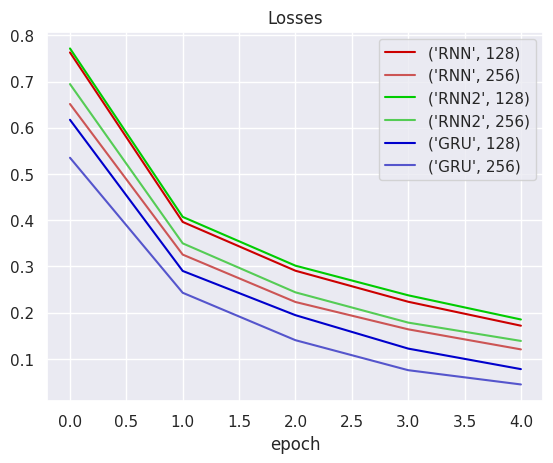

Лучшая accuracy для подхода ('RNN', 128): 85.60
Лучшая accuracy для подхода ('RNN', 256): 87.74
Лучшая accuracy для подхода ('RNN2', 128): 85.58
Лучшая accuracy для подхода ('RNN2', 256): 86.60
Лучшая accuracy для подхода ('GRU', 128): 88.06
Лучшая accuracy для подхода ('GRU', 256): 87.40


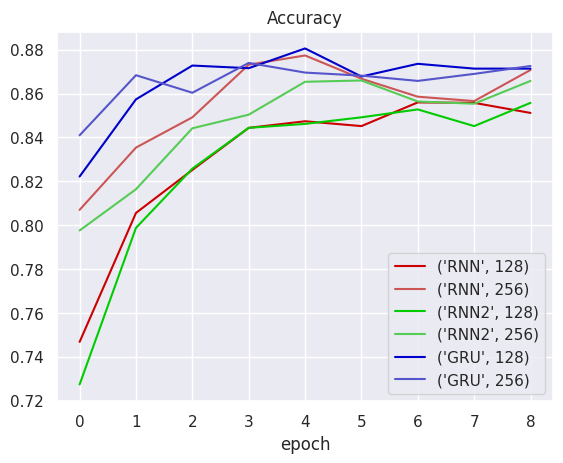

In [17]:
plot_losses(losses_exp)
plot_accuracies(acc_exp)

Модель GRU показала лучшую метрику, но к концу обучения метрика перестала расти.
В то же время у модели с двумя слоями RNN рост продолжался. Это может говорить о том,
что более сложная модель может выиграть от дальнейшего обучения.

Попробуем посчитать 10 эпох на модели с двумя слоями GRU c длиной эмбеддинга 256

In [18]:
# улучшаем наиболее перспективную модель 

emb_lens = [256]

num_epoch = 10
eval_steps = len(train_dataloader) // 2

losses_exp2 = {}
acc_exp2 = {}

m = '2xGRU'

for emb_len in emb_lens:
  print(f"Starting training 2xGRU model with emb len of {emb_len}")

  losses = []
  acc = []

  model = TextLM_GRU(
        hidden_dim=emb_len,
        vocab_size=len(vocab),
        num_layers=2,
        aggregation_type='mean'
                  ).to(device)

  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          #print('batch: ', batch.size())
          optimizer.zero_grad()
          logits = model(batch['input_ids'])
          # 32 x 4
          loss = criterion(logits, batch['label'])

          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())
          if (i+1) % eval_steps == 0:
              model.eval()
              eval_result = evaluate(model, eval_dataloader)
              acc.append(eval_result)
              print('eval results:', eval_result)
              model.train()

      losses.append(sum(epoch_losses) / len(epoch_losses))
      print('current loss:', sum(epoch_losses) / len(epoch_losses))
      print()

  losses_exp2[(m, emb_len)] = losses
  acc_exp2[(m, emb_len)] = acc

Starting training 2xGRU model with emb len of 256


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8881999850273132
eval results: 0.8995999693870544
current loss: 0.37723386961221694



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9083999991416931
eval results: 0.9109999537467957
current loss: 0.21635860509822766



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9101999998092651
eval results: 0.9111999869346619
current loss: 0.15178660905100405



Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9049999713897705
eval results: 0.9075999855995178
current loss: 0.10459612266526867



Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9075999855995178
eval results: 0.9077999591827393
current loss: 0.07580761298256306



Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9085999727249146
eval results: 0.9059999585151672
current loss: 0.059051244619853484



Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9052000045776367
eval results: 0.9041999578475952
current loss: 0.05126267087415327



Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.899399995803833
eval results: 0.9037999510765076
current loss: 0.04582764966332276



Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9009999632835388
eval results: 0.9109999537467957
current loss: 0.04239273452511601



Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9003999829292297
eval results: 0.8947999477386475
current loss: 0.04111719466918924



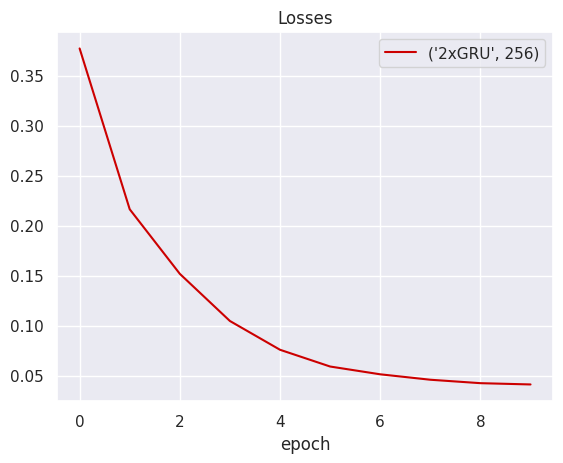

Лучшая accuracy для подхода ('2xGRU', 256): 91.12


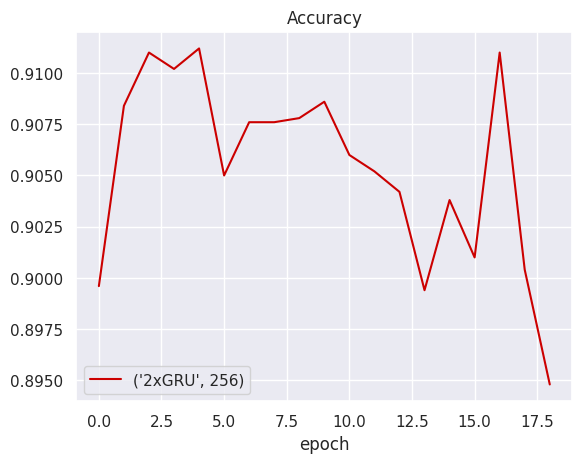

In [19]:
plot_losses(losses_exp2)
plot_accuracies(acc_exp2)

In [20]:
# попробуем сделать то же самое, но с большей длиной эмбеддинга,
# если это даст заметный результат - подберем лучшую длину

emb_lens = [400]

num_epoch = 10
eval_steps = len(train_dataloader) // 2

m = '2xGRU'

losses_exp3 = {}
acc_exp3 = {}

for emb_len in emb_lens:
  print(f"Starting training 2xGRU model with emb len of {emb_len}")

  losses = []
  acc = []

  model = TextLM_GRU(
        hidden_dim=emb_len,
        vocab_size=len(vocab),
        num_layers=2,
        aggregation_type='mean'
                  ).to(device)

  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          #print('batch: ', batch.size())
          optimizer.zero_grad()
          logits = model(batch['input_ids'])
          # 32 x 4
          loss = criterion(logits, batch['label'])

          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())
          if (i+1) % eval_steps == 0:
              model.eval()
              eval_result = evaluate(model, eval_dataloader)
              acc.append(eval_result)
              print('eval results:', eval_result)
              model.train()

      losses.append(sum(epoch_losses) / len(epoch_losses))
      print('current loss:', sum(epoch_losses) / len(epoch_losses))
      print()

  losses_exp3[(m, emb_len)] = losses
  acc_exp3[(m, emb_len)] = acc

Starting training 2xGRU model with emb len of 400


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8903999924659729
eval results: 0.8983999490737915
current loss: 0.36028036652505396



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8989999890327454
eval results: 0.911799967288971
current loss: 0.21265728131557504



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9075999855995178
eval results: 0.9159999489784241
current loss: 0.15017616306841375



Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9095999598503113
eval results: 0.9145999550819397
current loss: 0.10582719613015652



Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9129999876022339
eval results: 0.9103999733924866
current loss: 0.07970571095229437



Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9113999605178833
eval results: 0.9075999855995178
current loss: 0.06863213852550834



Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9095999598503113
eval results: 0.9027999639511108
current loss: 0.0589284729864914



Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9041999578475952
eval results: 0.9147999882698059
current loss: 0.058189828641642814



Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9145999550819397
eval results: 0.9081999659538269
current loss: 0.0533107198422115



Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9027999639511108
eval results: 0.8977999687194824
current loss: 0.05194043179117143



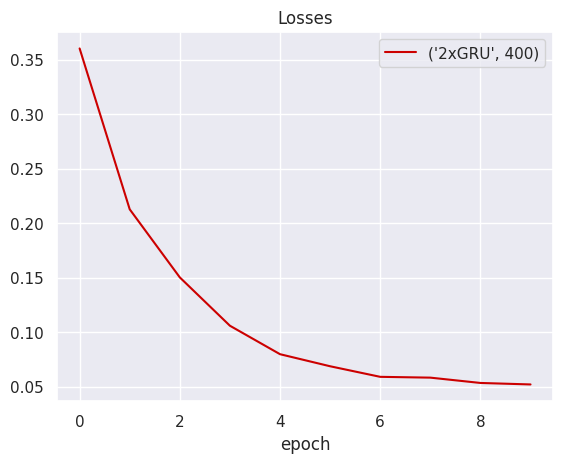

Лучшая accuracy для подхода ('2xGRU', 400): 91.60


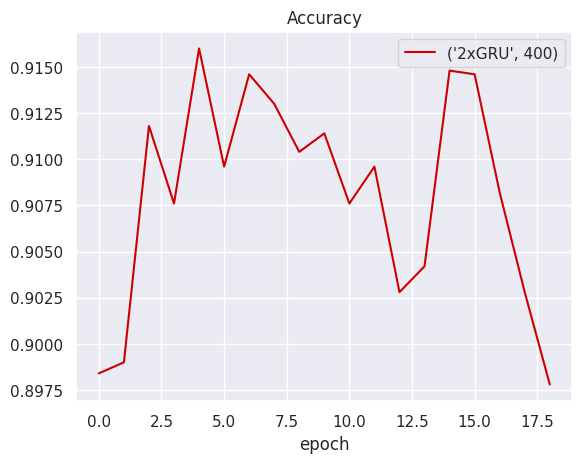

In [21]:
plot_losses(losses_exp3)
plot_accuracies(acc_exp3)

Результат выше 91.5% достигнут, но лишь формально - большая часть кривой ниже этой планки.

In [17]:
# Создадим альтернативную модель c 2xGRU и дропаут 20%

class TextLM_GRU_dr2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:  # на входе поступает batch_size * seq_len
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [18]:
# пробуем дропаут 20%

emb_lens = [256]

num_epoch = 10
eval_steps = len(train_dataloader) // 2

m = '2xGRU'

losses_exp4 = {}
acc_exp4 = {}

for emb_len in emb_lens:
  print(f"Starting training 2xGRU model with emb len of {emb_len}")

  losses = []
  acc = []

  model = TextLM_GRU_dr2(
        hidden_dim=emb_len,
        vocab_size=len(vocab),
        num_layers=2,
        aggregation_type='mean'
                  ).to(device)

  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          #print('batch: ', batch.size())
          optimizer.zero_grad()
          logits = model(batch['input_ids'])
          # 32 x 4
          loss = criterion(logits, batch['label'])

          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())
          if (i+1) % eval_steps == 0:
              model.eval()
              eval_result = evaluate(model, eval_dataloader)
              acc.append(eval_result)
              print('eval results:', eval_result)
              model.train()

      losses.append(sum(epoch_losses) / len(epoch_losses))
      print('current loss:', sum(epoch_losses) / len(epoch_losses))
      print()

  losses_exp4[(m, emb_len)] = losses
  acc_exp4[(m, emb_len)] = acc

Starting training 2xGRU model with emb len of 256


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8835999965667725
eval results: 0.8881999850273132
current loss: 0.3744719658911228



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9070000052452087
eval results: 0.9063999652862549
current loss: 0.2215702087630828



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9103999733924866
eval results: 0.9109999537467957
current loss: 0.15532136982418596



Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9093999862670898
eval results: 0.9097999930381775
current loss: 0.1086015022388349



Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9025999903678894
eval results: 0.9079999923706055
current loss: 0.07914705242576699



Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8989999890327454
eval results: 0.9037999510765076
current loss: 0.0632074645725855



Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9065999984741211
eval results: 0.9057999849319458
current loss: 0.05150426314792906



Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8998000025749207
eval results: 0.9089999794960022
current loss: 0.04721802436334547



Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8989999890327454
eval results: 0.9055999517440796
current loss: 0.0444249785082764



Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9043999910354614
eval results: 0.8987999558448792
current loss: 0.03979318508603998



NameError: name 'losses_exp3' is not defined

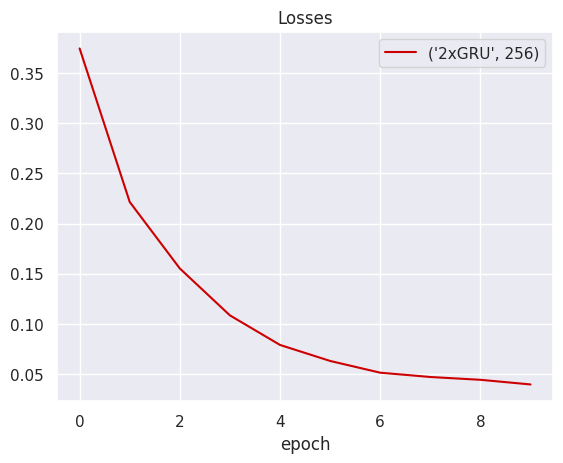

Лучшая accuracy для подхода ('2xGRU', 256): 91.10


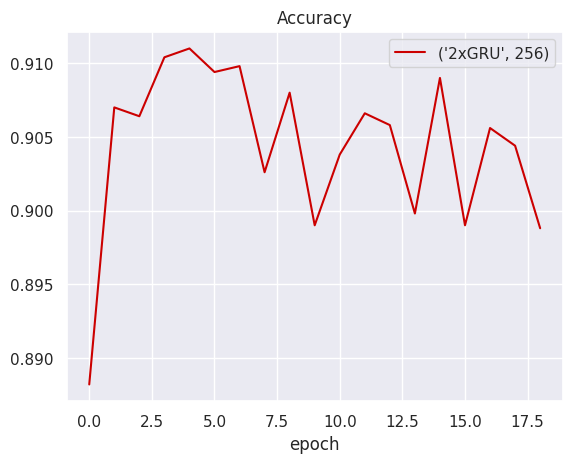

In [19]:
plot_losses(losses_exp4)
plot_accuracies(acc_exp4)

In [25]:
# пробуем собрать вместе дропаут 20%, эмбеддинг 400 и словарь 15к слов

emb_lens = [400]

num_epoch = 10
eval_steps = len(train_dataloader) // 2

m = '2xGRU, DO 20%, vocab 15k'

losses_exp5 = {}
acc_exp5 = {}

for emb_len in emb_lens:
  print(f"Starting training 2xGRU model with emb len of {emb_len} and vocab size of {len(vocab)}")

  losses = []
  acc = []

  model = TextLM_GRU_dr2(
        hidden_dim=emb_len,
        vocab_size=len(vocab),
        num_layers=2,
        aggregation_type='mean'
                  ).to(device)

  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          #print('batch: ', batch.size())
          optimizer.zero_grad()
          logits = model(batch['input_ids'])
          # 32 x 4
          loss = criterion(logits, batch['label'])

          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())
          if (i+1) % eval_steps == 0:
              model.eval()
              eval_result = evaluate(model, eval_dataloader)
              acc.append(eval_result)
              print('eval results:', eval_result)
              model.train()

      losses.append(sum(epoch_losses) / len(epoch_losses))
      print('current loss:', sum(epoch_losses) / len(epoch_losses))
      print()

  losses_exp5[(m, emb_len)] = losses
  acc_exp5[(m, emb_len)] = acc

Starting training 2xGRU model with emb len of 400 and vocab size of 15764


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8913999795913696
eval results: 0.9059999585151672
current loss: 0.36124951300124325



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9149999618530273
eval results: 0.9179999828338623
current loss: 0.20845475269407035



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9145999550819397
eval results: 0.9145999550819397
current loss: 0.1420043784680466



Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9127999544143677
eval results: 0.9139999747276306
current loss: 0.10288560122077664



Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9163999557495117
eval results: 0.9083999991416931
current loss: 0.07767650756930622



Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9143999814987183
eval results: 0.9133999943733215
current loss: 0.06483596292685252



Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9093999862670898
eval results: 0.91239994764328
current loss: 0.05898035805027466



Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9111999869346619
eval results: 0.9075999855995178
current loss: 0.05377508533682752



Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9055999517440796
eval results: 0.9081999659538269
current loss: 0.05061523058916597



Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9121999740600586
eval results: 0.9071999788284302
current loss: 0.04666870872516884



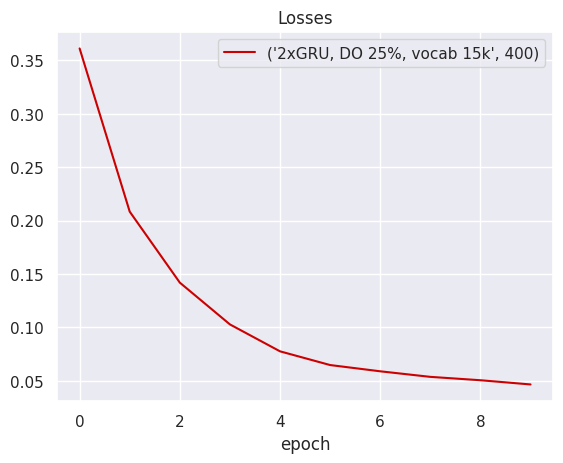

Лучшая accuracy для подхода ('2xGRU, DO 25%, vocab 15k', 400): 91.80


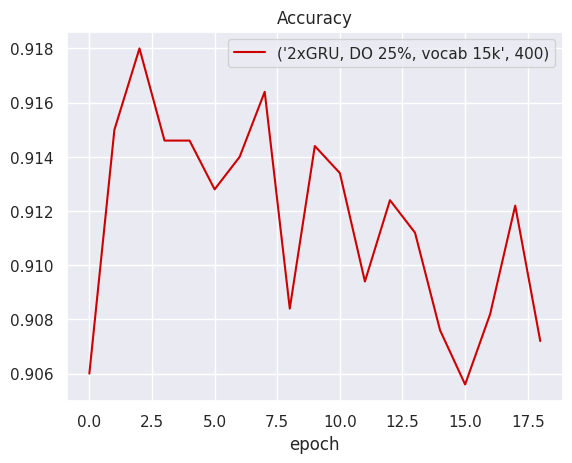

In [27]:
plot_losses(losses_exp5)
plot_accuracies(acc_exp5)

In [33]:
# пробуем собрать вместе дропаут 20%, эмбеддинг 512 и словарь 15к слов

emb_lens = [512]

num_epoch = 5
eval_steps = len(train_dataloader) // 2

m = '2xGRU, DO 20%, vocab 15k'

losses_exp5 = {}
acc_exp5 = {}

for emb_len in emb_lens:
  print(f"Starting training 2xGRU model with emb len of {emb_len} and vocab size of {len(vocab)}")

  losses = []
  acc = []

  model = TextLM_GRU_dr2(
        hidden_dim=emb_len,
        vocab_size=len(vocab),
        num_layers=2,
        aggregation_type='mean'
                  ).to(device)

  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          #print('batch: ', batch.size())
          optimizer.zero_grad()
          logits = model(batch['input_ids'])
          # 32 x 4
          loss = criterion(logits, batch['label'])

          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())
          if (i+1) % eval_steps == 0:
              model.eval()
              eval_result = evaluate(model, eval_dataloader)
              acc.append(eval_result)
              print('eval results:', eval_result)
              model.train()

      losses.append(sum(epoch_losses) / len(epoch_losses))
      print('current loss:', sum(epoch_losses) / len(epoch_losses))
      print()

  losses_exp5[(m, emb_len)] = losses
  acc_exp5[(m, emb_len)] = acc

Starting training 2xGRU model with emb len of 512 and vocab size of 15764


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8955999612808228
eval results: 0.9055999517440796
current loss: 0.35501160040150087



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9047999978065491
eval results: 0.9059999585151672
current loss: 0.21189343290403484



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9070000052452087
eval results: 0.9147999882698059
current loss: 0.15044789654376606



Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9089999794960022
eval results: 0.9109999537467957
current loss: 0.11126642419161896



Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9061999917030334
eval results: 0.9053999781608582
current loss: 0.08753354948686125



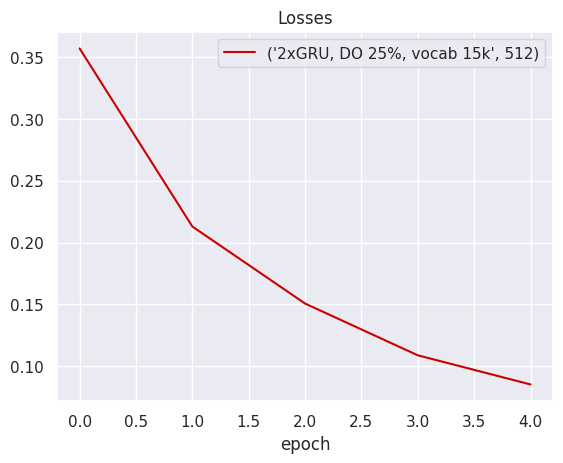

Лучшая accuracy для подхода ('2xGRU, DO 25%, vocab 15k', 512): 91.10


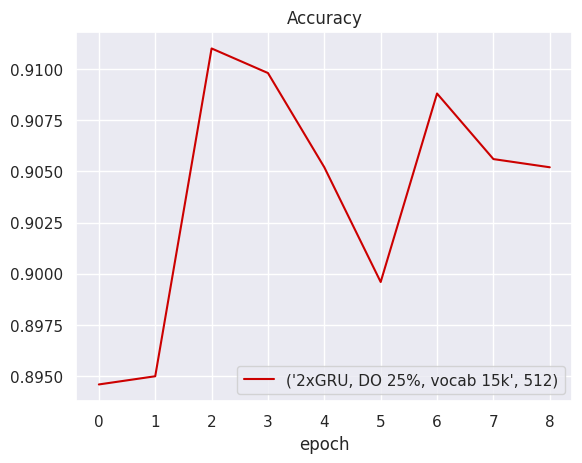

In [32]:
plot_losses(losses_exp5)
plot_accuracies(acc_exp5)

In [45]:
# В итоговой модели применим все, что узнали из экспериментов:
# 3 слоя GRU
# длина скрытого представления - 512
# Дропаут 20%
# словарь 15 к
# 3 эпохи

class TextLM_GRU_dr2m(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:  # на входе поступает batch_size * seq_len
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.non_lin(self.linear1(output)))  # [batch_size, hidden_dim]
        output = self.dropout(self.non_lin(self.linear2(output)))
        prediction = self.projection(output)  # [batch_size, num_classes]

        return prediction
    

# пробуем дропаут 20%

emb_lens = [512]

num_epoch = 3
eval_steps = len(train_dataloader) // 2

m = '3xGRU'

losses_exp6 = {}
acc_exp6 = {}

for emb_len in emb_lens:
  print(f"Starting training 2xGRU model with emb len of {emb_len}")

  losses = []
  acc = []

  model = TextLM_GRU_dr2m(
        hidden_dim=emb_len,
        vocab_size=len(vocab),
        num_layers=3,
        aggregation_type='mean'
                  ).to(device)

  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          #print('batch: ', batch.size())
          optimizer.zero_grad()
          logits = model(batch['input_ids'])
          # 32 x 4
          loss = criterion(logits, batch['label'])

          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())
          if (i+1) % eval_steps == 0:
              model.eval()
              eval_result = evaluate(model, eval_dataloader)
              acc.append(eval_result)
              print('eval results:', eval_result)
              model.train()

      losses.append(sum(epoch_losses) / len(epoch_losses))
      print('current loss:', sum(epoch_losses) / len(epoch_losses))
      print()

  losses_exp6[(m, emb_len)] = losses
  acc_exp6[(m, emb_len)] = acc

Starting training 2xGRU model with emb len of 512


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.8773999810218811
eval results: 0.9009999632835388
current loss: 0.4059576974307497



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.902999997138977
eval results: 0.915399968624115
current loss: 0.2500513887241483



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

eval results: 0.9075999855995178
eval results: 0.9151999950408936
current loss: 0.19693378769258657



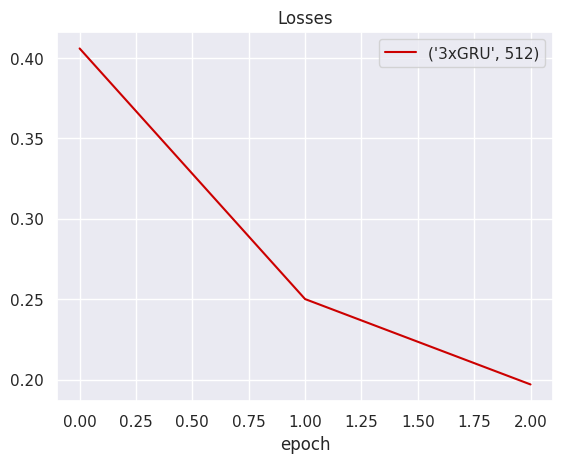

Лучшая accuracy для подхода ('3xGRU', 512): 91.54


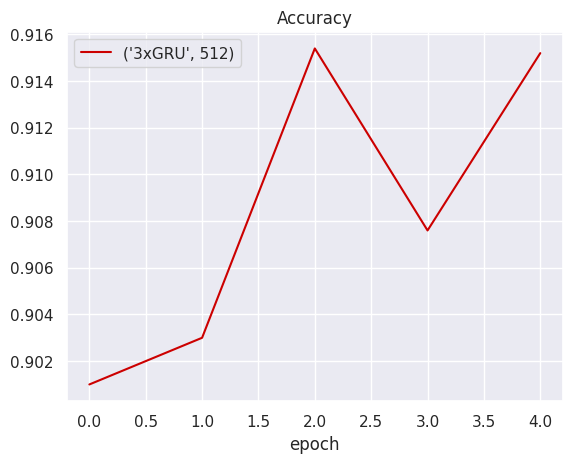

In [46]:
plot_losses(losses_exp6)
plot_accuracies(acc_exp6)

Наконец-то относительно стабильный вариант!

In [52]:
model.eval()
eval_result = evaluate(model, eval_dataloader)
print('eval results:', round(eval_result,4))

eval results: 0.9152


# Отчет о проделанной работе

В качестве кода модели, функций проверки и оценки был использован код из семинара. В него были внесены незначительные изменения.

Первый прогон с базовой моделью дал следующие результаты (код не сохранен):

Лучшая accuracy для подхода max: 90.52
Лучшая accuracy для подхода mean: 90.76

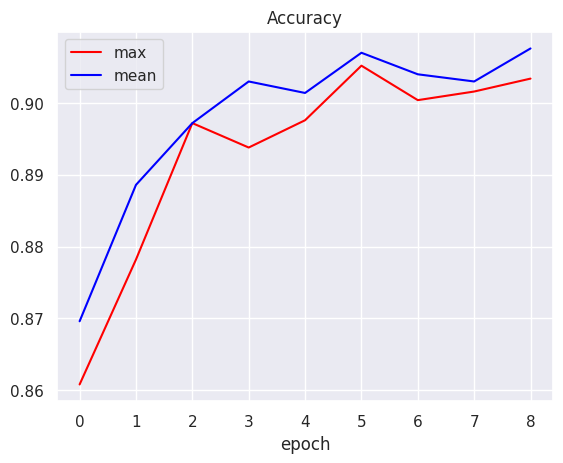



Для поиска подходящей модели был проведен "Grid search" по укороченному циклу исходя из предположения, что обучение на 1/4 датасета должно дать достаточно репрезентативные данные для сравнения.

Далее будет использован только подход mean. Из-за больших затрат времени на вычисления не представляется возможным прогнать все комбинации параметров, хотя *по-хорошему* выбор mean/max не обязательно сохранится для других моделей и параметров.

Для эксперимента были созданы модели с одним и двумя слоями RNN, а также модель со слоем GRU, идентичные по остальным элементам.

В 6 экспериментах (из трех моделей и двух длин скрытого представления (эмбеддинга)) наметился лидер: модель со слоем GRU. Однако есть и неопределенность: после 5 эпох ее accuracy как будто перестала расти. Выводы сделаны на сокращенном датасете.

Проведем дополнительный эксперимент с перспективной моделью: используем архитектуру GRU, но будем учить 10 эпох на полном датасете.

Если нужный результат не будет получен, продолжим поиски.

Результаты 6 прогонов:
* 
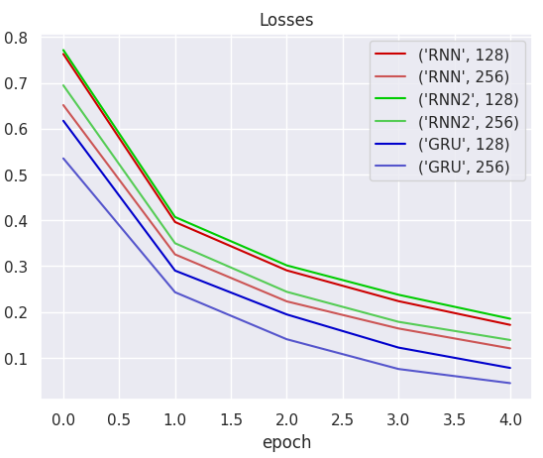
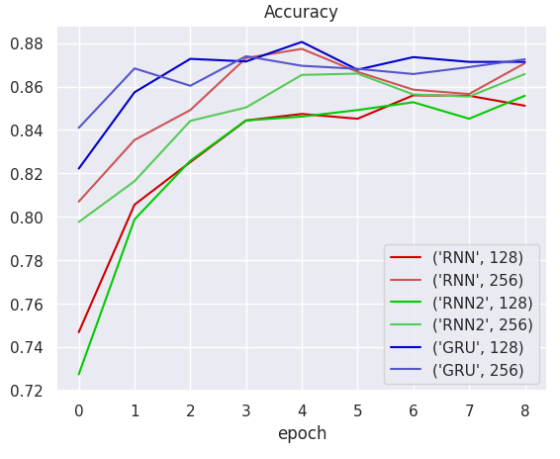

Попытка дообучить сеть на большем числе эпох не привела к улучшению метрики на evaluation. Лоссы продолжили падать, но видимо, это уже переобучение.

## Более долгое обучение
Обучение сети с 2 слоями GRU 10 эпох

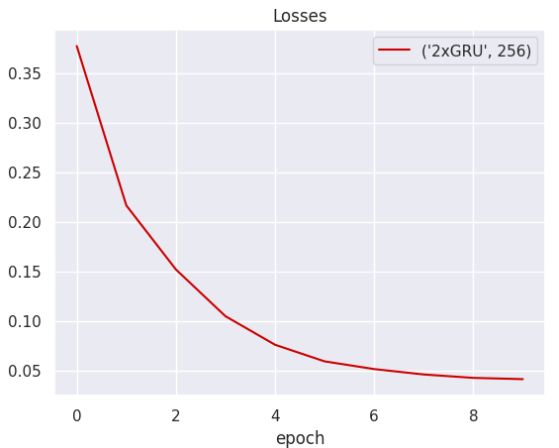
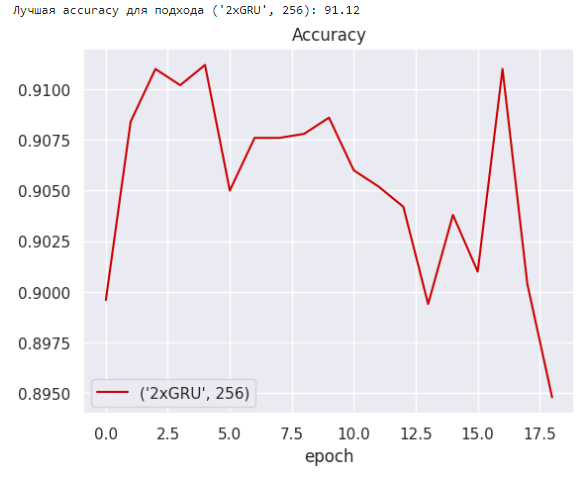


## Большая длина эмбеддинга
Далее предпринята попытка улучшить такую же сеть за счет большей длины эмбеддинга:

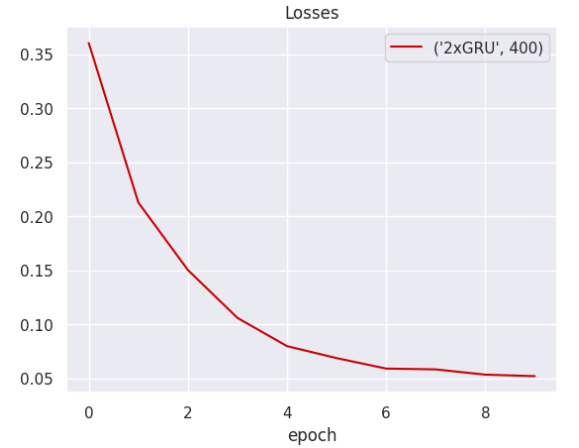
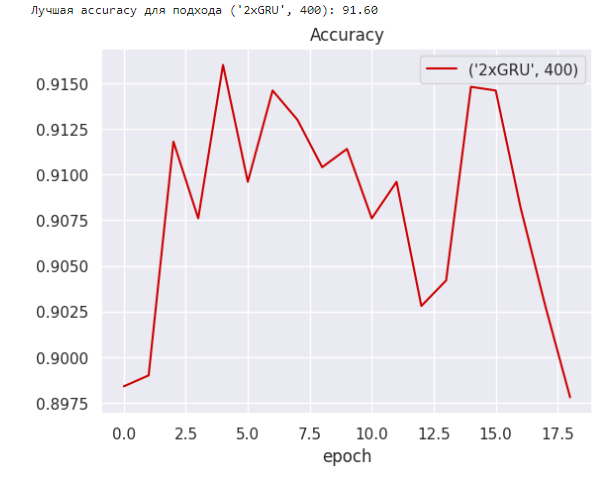

## Варьируем дропаут
Наконец, та же сеть с длиной эмбеддинга 256 обучена с дропаутом 20%

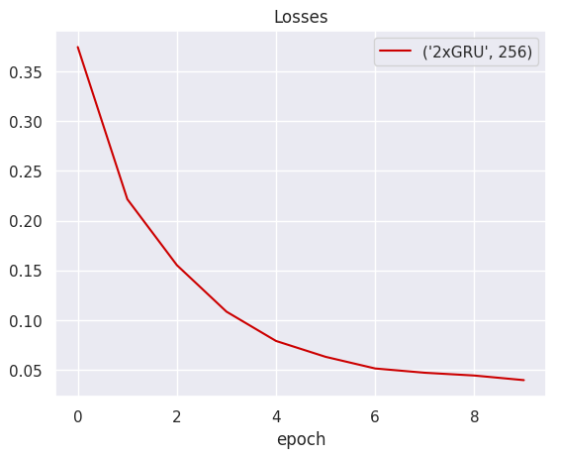
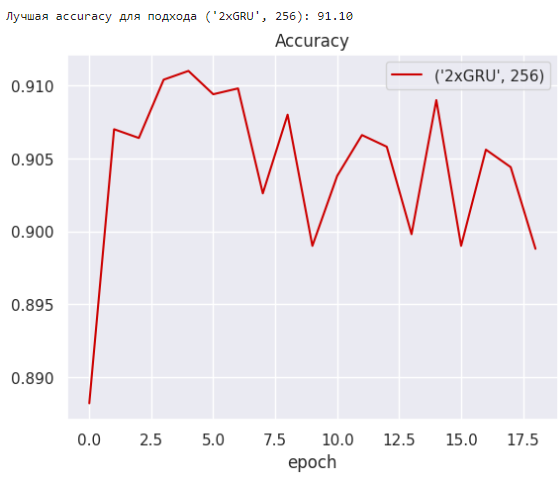


## Предварительный результат
Наконец, становится ясно, что число эпох не работает на улучшение метрик, и при увеличенном словаре мы достигаем 91.5% уже в первые три эпохи. Ниже приведен прогон и с дропаутом и с увеличенной длиной эмбеддинга

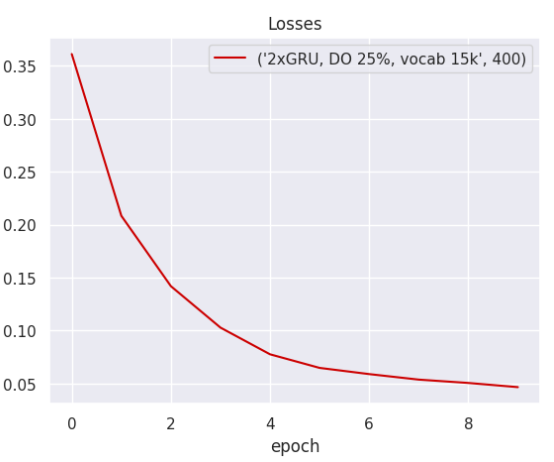
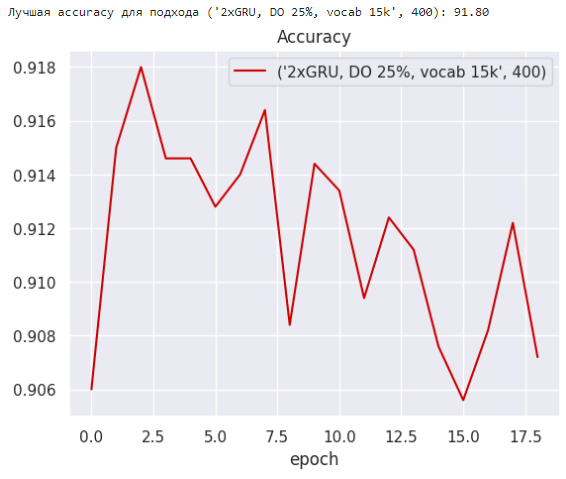


## Финальная модель
Попробуем еще чуть увеличить результат и закончим на этом.

У прошлых сетей был явный недостаток - после достижения максимальной метрики показатели начинают существенно падать. 

Попробовал изменить архитектуру сети, изменив порядок применения функции активации и добавив третий слой GRU.

Эксперимент с ранее использованными параметрами (эмбеддинг 512, дропаут 20%, словарь 15 к слов) на трех эпохах дает достичь нужного результата.

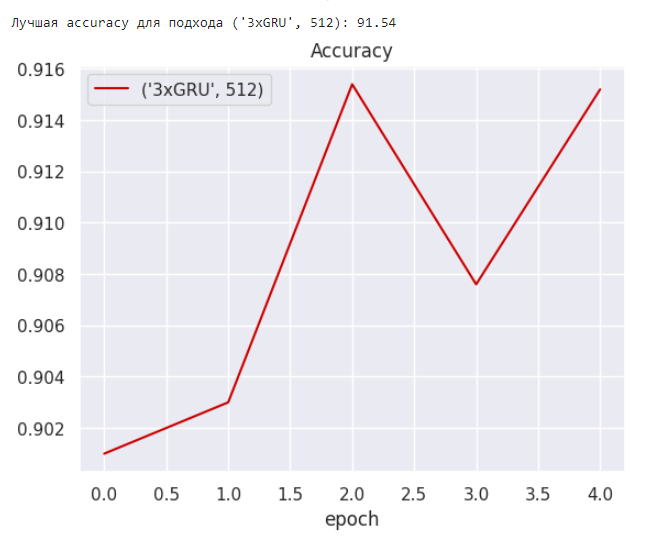

Видно, что после трех эпох модель довольно берет планку 91.5%

Представляется, что за счет более тщательного подбора гиперпараметров сети с выбранной архитектурой метрика может быть стабилизирована еще лучше. В силу больших затрат вычислительного времени на такой подбор по сетке, я его не выполнял. 

## Вывод
Таким образом, важнейшими положительными факторами оказались:
* архитектура (GRU vs RNN, число слоев),
* увеличение длины эмбеддинга,
* увеличение объема словаря;

Множитель дропаута оказал на метрику двоякое воздействие - несколько снизил ее пиковые значения, но сделал более стабильной.

В лучшей модели достигнута метрика 0.918, однако ее стабильность под вопросом. Уверенно получается 0.915.

## Направления улучшения
Весь код очень трудно читать, его на основе полученного опыта необходимо обернуть в функции, которые будут принимать все параметры на входе, и не дублировать "простыни". Для того, чтобы успеть сдать домашку в выходные, этот момент скипнут.

In [22]:
#save embeddings to file
learned_embs = model.embedding.weight.cpu().data.numpy()
np.save('embeddings.npy', learned_embs)

#load back from file
embeddings = np.load('embeddings.npy')
model.embedding.weight = nn.Parameter(torch.Tensor(embeddings))

